# Example 1: Inference for a Normal Mean

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]


Output()

Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

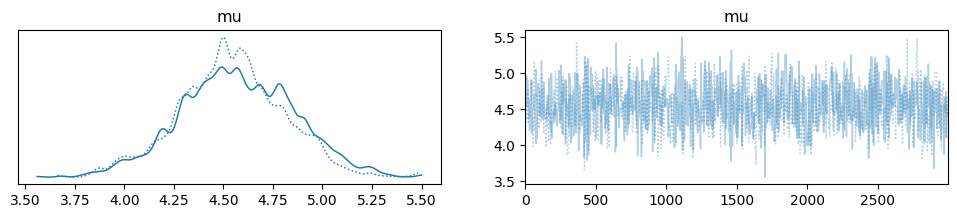

In [1]:
import pymc as pm
import arviz as az
import numpy as np

np.random.seed(42)
y = np.random.normal(loc=5, scale=2, size=50)

with pm.Model() as mh_model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = 2.0
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    idata = pm.sample(3000, tune=2000, chains=2, step=pm.Metropolis())

az.plot_trace(idata, var_names=["mu"])


<Axes: title={'center': 'mu'}>

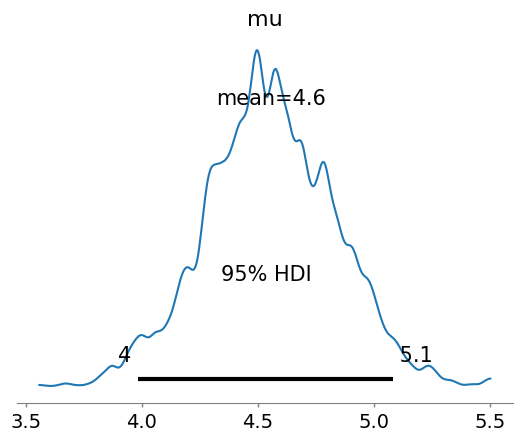

In [2]:
az.plot_posterior(idata, var_names=["mu"], hdi_prob=0.95)


# Example 2: Bayesian Linear Regression

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'beta0'}>,
       <Axes: title={'center': 'beta1'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

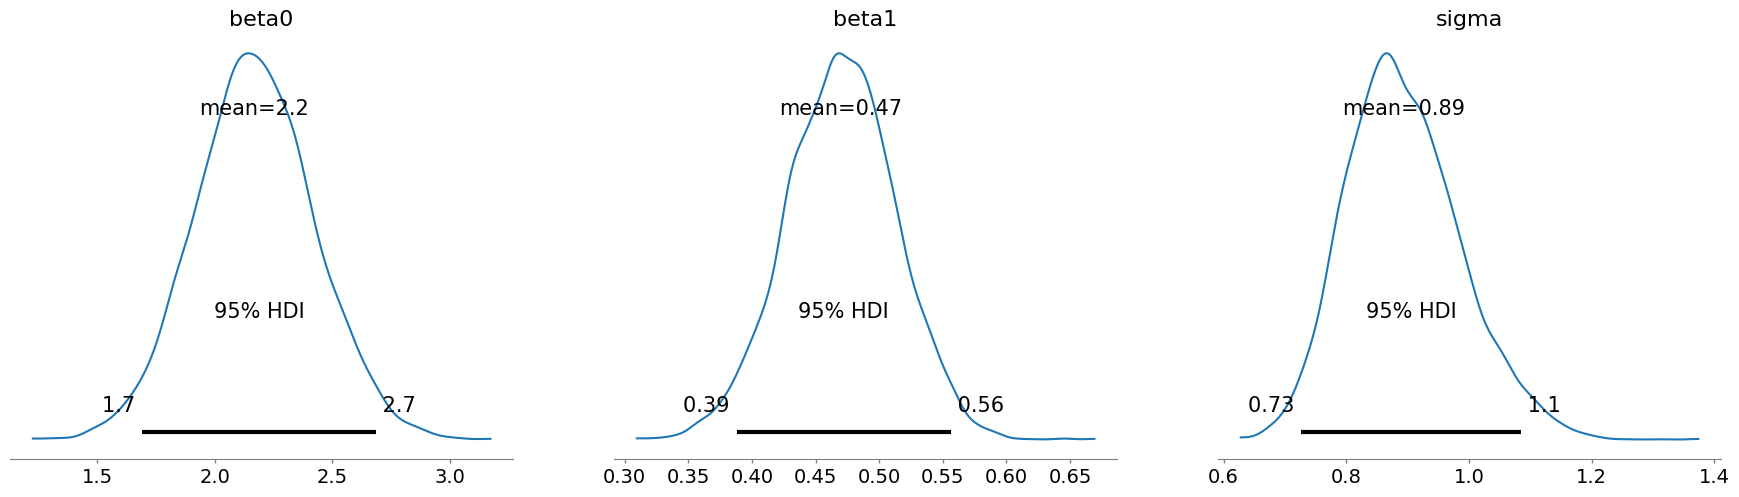

In [3]:
x = np.linspace(0, 10, 50)
y = 2 + 0.5*x + np.random.normal(0, 1, 50)

with pm.Model() as reg_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    idata = pm.sample(3000, tune=2000, chains=2, target_accept=0.95)

az.plot_posterior(idata, var_names=["beta0","beta1","sigma"], hdi_prob=0.95)


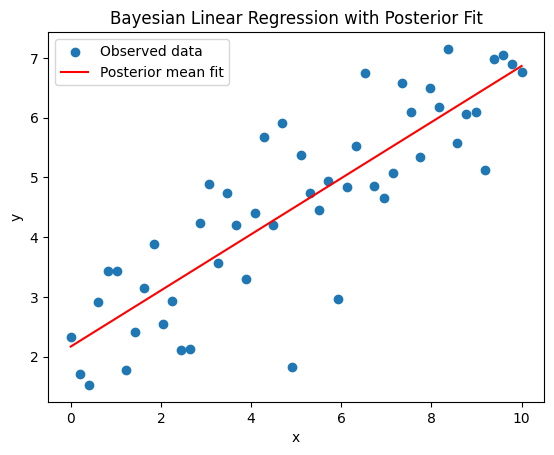

In [4]:
import matplotlib.pyplot as plt

beta0_samples = idata.posterior["beta0"].mean().values
beta1_samples = idata.posterior["beta1"].mean().values

plt.scatter(x, y, label="Observed data")
plt.plot(x, beta0_samples + beta1_samples*x, color="red", label="Posterior mean fit")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Bayesian Linear Regression with Posterior Fit")
plt.show()


# MCMC for Daily Crime Counts in Chicago



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Analytic posterior mean E[λ|y] = 695.241
Analytic 95% CI for λ        = [694.426, 696.057]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.



MCMC posterior summary for λ:
           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
lambda  695.228  0.414   694.426    696.034      0.008    0.006    2669.0   

        ess_tail  r_hat  
lambda    2658.0    1.0  


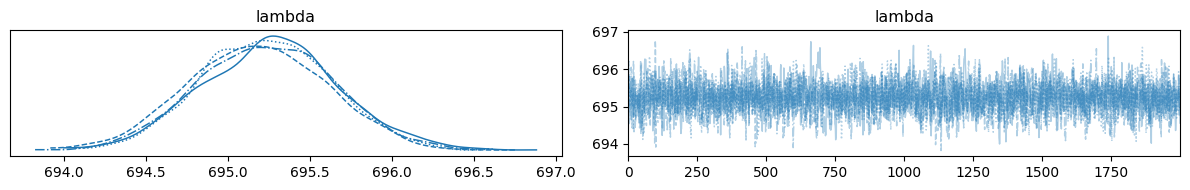

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma

daily = pd.read_csv("daily_counts.csv") 
y = daily['count'].to_numpy()
T = y.size
S = y.sum()

alpha0, beta0 = 1.0, 1.0
alpha_post = alpha0 + S
beta_post  = beta0 + T
analytic_mean = alpha_post / beta_post
analytic_ci   = gamma(a=alpha_post, scale=1.0/beta_post).ppf([0.025, 0.975])

print(f"Analytic posterior mean E[λ|y] = {analytic_mean:.3f}")
print(f"Analytic 95% CI for λ        = [{analytic_ci[0]:.3f}, {analytic_ci[1]:.3f}]")

with pm.Model() as m_city:
    lam = pm.Exponential("lambda", 1.0)         
    obs = pm.Poisson("obs", mu=lam, observed=y) 
    trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, random_seed=42)

summ = az.summary(trace, var_names=["lambda"], hdi_prob=0.95)
print("\nMCMC posterior summary for λ:")
print(summ)

fig_trace = az.plot_trace(trace, var_names=["lambda"])
plt.tight_layout()
plt.savefig("fig_3X_trace_lambda.png", dpi=300)



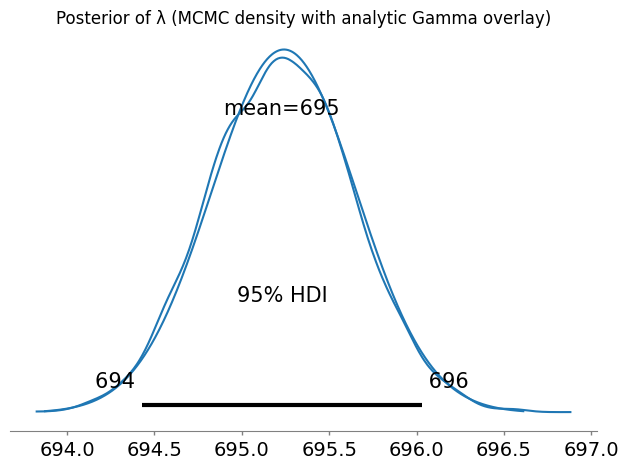

In [9]:
fig, ax = plt.subplots()
az.plot_posterior(trace, var_names=["lambda"], hdi_prob=0.95, ax=ax)
grid = np.linspace(max(1e-6, gamma.ppf(0.0005, a=alpha_post, scale=1.0/beta_post)),
                   gamma.ppf(0.9995, a=alpha_post, scale=1.0/beta_post), 800)
ax.plot(grid, gamma.pdf(grid, a=alpha_post, scale=1.0/beta_post), lw=1.5)
ax.set_title("Posterior of λ (MCMC density with analytic Gamma overlay)")
plt.tight_layout()
plt.savefig("fig_3Y_posterior_lambda_overlay.png", dpi=300)

Sampling: [obs]


Output()

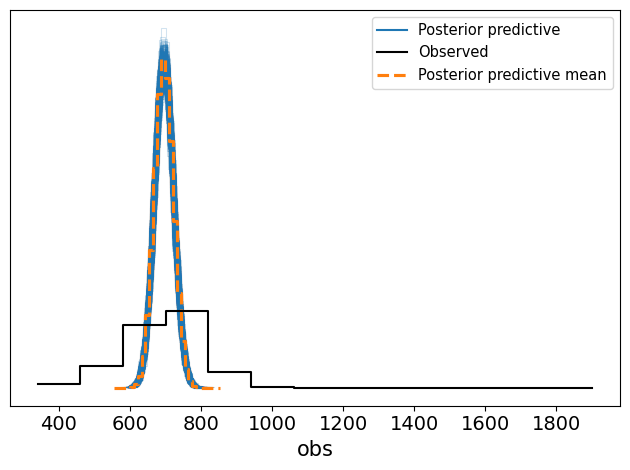

In [12]:
with m_city:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42, return_inferencedata=True)

fig_ppc = az.plot_ppc(ppc, kind="kde", num_pp_samples=400)
plt.tight_layout()
plt.savefig("fig_3Z_ppc_poisson_citywide.png", dpi=300)
